# Applied Machine Learning Homework 4 Question 1 

### Group 111
<br>Aryan Dhuru
<br>Saloni Gandhi
<br>Mitanshu Bhoot
<br>Shivali Mate


## CLIP (Contrastive Language-Image Pre-training)

Source: openai/clip-vit-base-patch32

### 1. Architecture

- **Image Encoder**:
    - **ResNet**:
    Includes variants like ResNet-50, ResNet-101, and scaled versions (e.g., RN50x64).
    Features ResNet-D enhancements, antialiased pooling, and attention pooling.
    - **Vision Transformer (ViT)**: The model uses a Vision Transformer as its backbone for processing images. Uses variants such as ViT-B/32 (86M parameters) and ViT-L/14 (307M parameters).

- **Text Encoder**: 
    - The text encoder is based on the GPT-2 architecture.
    - The input text is tokenized and embedded into vectors using a learned embedding layer.
    - Positional Encoding: Like the ViT, positional encodings are added to the token embeddings to retain the sequence information.


- **Shared Embedding Space**:
    - **Projection Layers**: 
    After the vision and text encoders process their respective inputs, the resulting embeddings are projected into a shared space using separate linear projection layers for images and text.
    - **Contrastive Learning**: 
    During training, CLIP uses a contrastive loss to align the image and text embeddings in this shared space. Matching pairs (image and its corresponding caption) are brought closer together, while non-matching pairs are pushed apart.

### 2. Number of Layers and Parameters

- **Vision Transformer (ViT)**: 
    - The Vision Transformer used in CLIP has 12 layers with 512 hidden units and 8 attention heads.
    - Typical parameter count: ~23M for ResNet-50.
- **Text Encoder (GPT-2)**: 
    - The text encoder used in CLIP has 24 layers.
    - Typical parameter count: ~63M.

### Parameters Breakdown

- **Embedding Layer**: Converts input images/text into embeddings.
- **Transformer Layers**: Each layer consists of multi-head self-attention mechanisms and feed-forward neural networks.
- **Parameters**: The parameters include weights for the attention mechanism, feed-forward networks, and normalization layers.
- **K, Q, V Matrices**: These are part of the self-attention mechanism, where K (Key), Q (Query), and V (Value) matrices are used to compute attention scores.

### 3. Functionality

- **Image and Text Embeddings**: The model learns to map images and text into a shared embedding space.
- **Contrastive Loss**: The model is trained using a contrastive loss function, which encourages the embeddings of matching image-text pairs to be closer together, while non-matching pairs are pushed apart.
- **Zero-Shot Transfer**: After pre-training, the model can perform tasks without additional training by leveraging natural language descriptions.

### 4. Training and Objectives
- The model is trained on a dataset of 400M image-text pairs using a contrastive loss to maximize similarity between correct pairs and minimize similarity for incorrect ones.
- Zero-shot transfer is achieved by encoding class names or descriptions as text embeddings and comparing them to image embeddings.


In [5]:
import os
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Set up device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model
model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

# Define the dataset directory and categories
data_dir = "./dataset"  # Replace with your dataset directory
categories = ["airplane", "car", "chair", "cup", "dog", "donkey", "duck", "hat"]
conditions = ["blurred", "features", "geons", "realistic", "silhouettes"]

In [7]:
def count_images_per_category(data_dir, categories, conditions):
    category_counts = {condition: {category: 0 for category in categories} for condition in conditions}

    for condition in conditions:
        condition_dir = os.path.join(data_dir, condition)

        for category in categories:
            category_images = [f for f in os.listdir(condition_dir) if f.lower().startswith(category)]
            category_counts[condition][category] = len(category_images)

    return category_counts


# Count the number of images per category
image_counts = count_images_per_category(data_dir, categories, conditions)

# Print the number of images per category
print("Number of images per category:")
for condition, counts in image_counts.items():
    print(f"Condition: {condition}")
    for category, count in counts.items():
        print(f"  {category}: {count}")

Number of images per category:
Condition: blurred
  airplane: 6
  car: 5
  chair: 6
  cup: 5
  dog: 5
  donkey: 4
  duck: 6
  hat: 5
Condition: features
  airplane: 6
  car: 5
  chair: 5
  cup: 5
  dog: 5
  donkey: 4
  duck: 6
  hat: 5
Condition: geons
  airplane: 8
  car: 8
  chair: 7
  cup: 8
  dog: 7
  donkey: 7
  duck: 7
  hat: 7
Condition: realistic
  airplane: 5
  car: 5
  chair: 5
  cup: 5
  dog: 6
  donkey: 5
  duck: 5
  hat: 5
Condition: silhouettes
  airplane: 5
  car: 5
  chair: 5
  cup: 6
  dog: 4
  donkey: 5
  duck: 5
  hat: 5


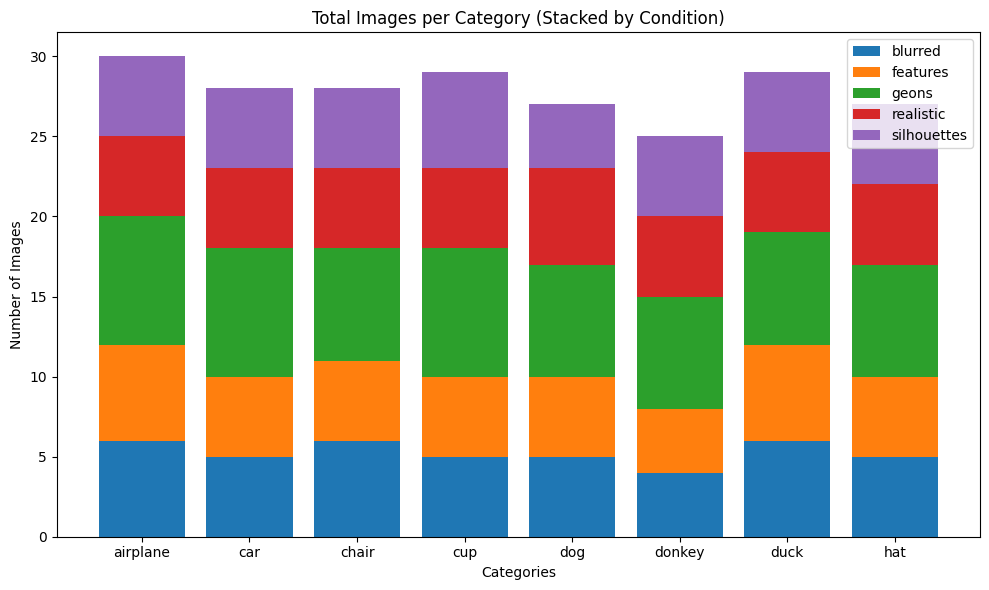

In [8]:
# Stacked bar chart of total images per category
fig, ax = plt.subplots(figsize=(10, 6))

category_totals = np.zeros(len(categories))
for condition in conditions:
    counts = [image_counts[condition][cat] for cat in categories]
    ax.bar(categories, counts, bottom=category_totals, label=condition)
    category_totals += np.array(counts)

# Add labels, title, and legend
ax.set_xlabel('Categories')
ax.set_ylabel('Number of Images')
ax.set_title('Total Images per Category (Stacked by Condition)')
ax.legend()

plt.tight_layout()
plt.show()


In [9]:
def evaluate_model(data_dir, categories, conditions):
    accuracy = {condition: 0 for condition in conditions}

    for condition in conditions:
        correct = 0
        total = 0
        condition_dir = os.path.join(data_dir, condition)

        for category in categories:
            category_images = [f for f in os.listdir(condition_dir) if f.lower().startswith(category)]

            for img_name in tqdm(category_images, desc=f"Evaluating {condition}/{category}"):
                img_path = os.path.join(condition_dir, img_name)
                image = Image.open(img_path).convert("RGB")

                inputs = processor(text=categories, images=image, return_tensors="pt", padding=True)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                outputs = model(**inputs)

                logits_per_image = outputs.logits_per_image
                probs = logits_per_image.softmax(dim=-1)

                # Get the predicted category
                pred = torch.argmax(probs).item()
                if categories[pred] == category:
                    correct += 1
                total += 1

        # Avoid division by zero
        if total > 0:
            accuracy[condition] = correct / total
        else:
            accuracy[condition] = 0  # Assign 0 accuracy if no images were processed

    return accuracy
# Evaluate the model
accuracy = evaluate_model(data_dir, categories, conditions)

# Print the accuracy
for condition, acc in accuracy.items():
    print(f"Accuracy for {condition}: {acc * 100:.2f}%")


Evaluating silhouettes/hat: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

Accuracy for blurred: 69.05%
Accuracy for features: 80.49%
Accuracy for geons: 54.24%
Accuracy for realistic: 100.00%
Accuracy for silhouettes: 92.50%


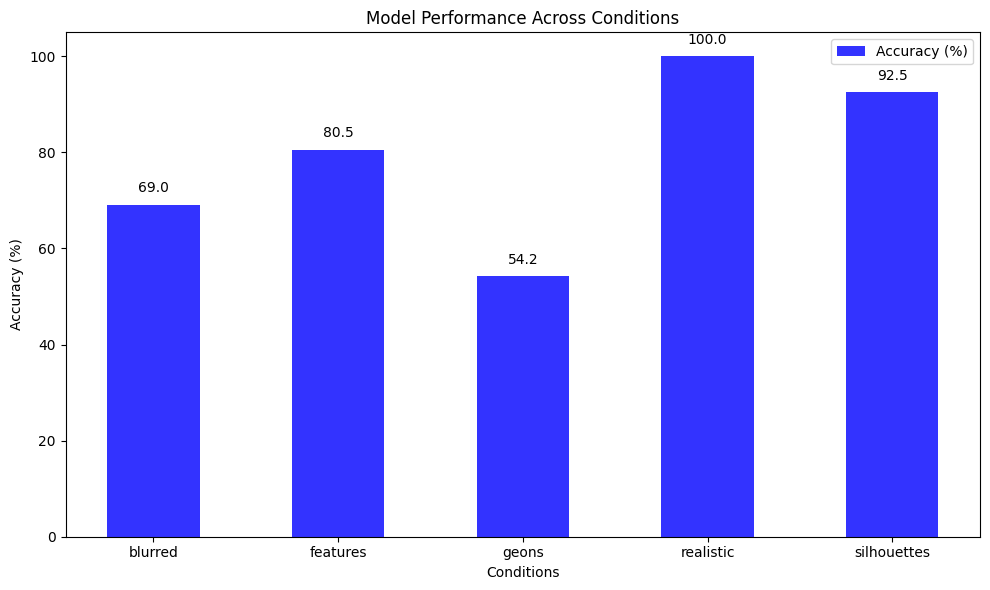

In [10]:

# Combined bar graph for all conditions
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart data
conditions = list(accuracy.keys())
accuracies = [acc * 100 for acc in accuracy.values()]

bar_width = 0.5
x = np.arange(len(conditions))

# Plotting bars
bars = ax.bar(x, accuracies, bar_width, label='Accuracy (%)', color='blue', alpha=0.8)

# Add labels, title, and legend
ax.set_xlabel('Conditions')
ax.set_title('Model Performance Across Conditions')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
ax.set_ylabel('Accuracy (%)')
ax.legend()

# Add data labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{height:.1f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Comparison of Model and Babies' Performance Across Conditions

## 1. Blurred
- **Model Accuracy**: 69.05%
- **Babies' Performance**: Moderate, as infants rely on the overall shape and structure for object recognition.
- **Comparison**:
  - The model performs reasonably well in this condition, demonstrating robustness to blurring effects, which aligns with infants' moderate performance.
  - **Similar performance compared to infants.**

---

## 2. Features
- **Model Accuracy**: 80.49%
- **Babies' Performance**: Low, as infants often require holistic visual context and struggle with isolated features.
- **Comparison**:
  - The model significantly outperforms infants. This is expected since models like CLIP are trained to leverage isolated discriminative features for classification.
  - **Better than infants.**

---

## 3. Geons
- **Model Accuracy**: 54.24%
- **Babies' Performance**: Low to moderate, as geons are abstract representations and can be challenging without prior experience.
- **Comparison**:
  - The model shows moderate performance, but it still likely outperforms infants, who find abstract representations more difficult.
  - **Better than infants, though not as robust as other conditions.**

---

## 4. Realistic
- **Model Accuracy**: 100.00%
- **Babies' Performance**: High, as realistic images are closest to natural stimuli infants encounter in their environment.
- **Comparison**:
  - The model achieves perfect accuracy, reflecting its ability to generalize well with naturalistic images. Infants are also highly adept here, so both show high performance.
  - **Similar or slightly better performance compared to infants.**

---

## 5. Silhouettes
- **Model Accuracy**: 92.50%
- **Babies' Performance**: Moderate, as infants may rely on edge-based recognition but often require additional details.
- **Comparison**:
  - The model excels with silhouettes, leveraging edge-based and outline information, outperforming infants, who struggle more with such limited cues.
  - **Better than infants.**


In [11]:
# # Combined bar graph for all conditions
# fig, ax = plt.subplots(figsize=(10, 6))

# # Bar chart data
# conditions = list(accuracy.keys())
# accuracies = [acc * 100 for acc in accuracy.values()]

# bar_width = 0.5
# x = np.arange(len(conditions))

# # Plotting bars
# bars = ax.bar(x, accuracies, bar_width, label='Accuracy (%)', color='blue', alpha=0.8)

# # Add labels, title, and legend
# ax.set_xlabel('Conditions')
# ax.set_title('Model Performance Across Conditions')
# ax.set_xticks(x)
# ax.set_xticklabels(conditions)
# ax.set_ylabel('Accuracy (%)')
# ax.legend()

# # Add data labels
# for bar in bars:
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{height:.1f}',
#             ha='center', va='bottom', fontsize=10)

# plt.tight_layout()
# plt.show()

# # t-SNE Embedding Visualization
# # from sklearn.manifold import TSNE

# # # Function to extract embeddings and apply t-SNE
# # def tsne_embeddings(data_dir, categories, conditions):
# #     embeddings = []
# #     images = []

# #     for condition in conditions:
# #         condition_dir = os.path.join(data_dir, condition)
# #         for category in categories:
# #             category_images = [f for f in os.listdir(condition_dir) if f.lower().startswith(category)]
# #             for img_name in category_images:
# #                 img_path = os.path.join(condition_dir, img_name)
# #                 image = Image.open(img_path).convert("RGB")
# #                 images.append((image, img_path))
                
# #                 # Preprocess image
# #                 inputs = processor(images=image, return_tensors="pt").to(device)
# #                 vision_outputs = model.vision_model(**inputs)
# #                 embeddings.append(vision_outputs.last_hidden_state.mean(dim=1).squeeze(0).cpu().detach().numpy())

# #     # Apply t-SNE
# #     tsne = TSNE(n_components=2, random_state=42)
# #     reduced_embeddings = tsne.fit_transform(np.array(embeddings))
# #     return reduced_embeddings, images

# # # Extract and reduce embeddings
# # reduced_embeddings, images = tsne_embeddings(data_dir, categories, conditions)

# # # Plot t-SNE
# # fig, ax = plt.subplots(figsize=(12, 12))
# # ax.set_title("t-SNE Visualization of Image Embeddings")

# # for i, (x, y) in enumerate(reduced_embeddings):
# #     image, img_path = images[i]
# #     image = image.resize((20, 20))  # Resize for plotting
# #     img_arr = np.array(image)
# #     ax.imshow(img_arr, extent=(x - 5, x + 5, y - 5, y + 5), zorder=1)
# #     ax.scatter(x, y, marker='o', color='black', zorder=2)

# # plt.tight_layout()
# # plt.show()


In [13]:
# Apply t-SNE to reduce embeddings to 2D
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=42)
    return tsne.fit_transform(embeddings)
# Plot t-SNE results with images
def plot_tsne_with_images(reduced_embeddings, image_paths):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title("t-SNE Visualization of Image Embeddings")

    for i, (x, y) in enumerate(reduced_embeddings):
        img = Image.open(image_paths[i]).resize((20, 20))  # Resize for plotting
        img_arr = np.array(img)
        ax.imshow(img_arr, extent=(x - 5, x + 5, y - 5, y + 5), zorder=1)
        ax.scatter(x, y, marker='o', color='black', zorder=2)

    plt.tight_layout()
    plt.show()


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm

def plot_dimensionality_reduction_with_images(
    method='tsne', 
    X=None,  # Feature embeddings
    y=None,  # Labels or categories
    images=None,  # Images corresponding to embeddings
    min_distance=0.04, 
    figsize=(16, 8)
):
    """
    Plot 2D dimensionality reduction with optional images overlay.

    Args:
        method (str): The dimensionality reduction method ('tsne' or 'pca').
        X (ndarray): Feature embeddings (num_samples x num_features).
        y (list or ndarray): Labels for each embedding.
        images (list or ndarray): List of images corresponding to embeddings.
        min_distance (float): Minimum distance between overlaid images.
        figsize (tuple): Size of the plot.
    """
    # Choose the dimensionality reduction method
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Unsupported method. Choose 'pca' or 'tsne'.")

    # Normalize the data
    X_normalized = MinMaxScaler().fit_transform(X)
    reduced_data = reducer.fit_transform(X_normalized)

    # Create the plot
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Scatter plot of reduced data
    scatter = axes[0].scatter(
        reduced_data[:, 0], 
        reduced_data[:, 1], 
        c=y, 
        alpha=0.6, 
        cmap=plt.cm.viridis
    )
    axes[0].set_title(f"{method.upper()}: 2D Scatter Plot")
    axes[0].set_xlabel("Dimension 1")
    axes[0].set_ylabel("Dimension 2")
    axes[0].grid(True)
    plt.colorbar(scatter, ax=axes[0], label="Category")

    # Overlay images on the scatter plot
    axes[1].scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0)
    axes[1].set_title(f"{method.upper()}: 2D Projection with Images")
    axes[1].axis("off")

    # Add images to the scatter plot
    ax = axes[1]
    neighbors = np.array([[10., 10.]])  # Initialize with a distant point
    for index, image_coord in enumerate(tqdm(reduced_data, desc="Adding images to plot")):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]

            if images is not None:
                image = images[index]
                imagebox = AnnotationBbox(OffsetImage(image, zoom=0.2), image_coord, frameon=False)
                ax.add_artist(imagebox)

    plt.tight_layout()
    plt.show()

# Example usage (replace placeholders with your data):
# X: Feature embeddings (num_samples x num_features)
# y: Labels or categories (num_samples)
# images: List of corresponding images (num_samples)

# plot_dimensionality_reduction_with_images(method='tsne', X=feature_embeddings, y=labels, images=image_list)


NameError: name 'feature_embeddings' is not defined